In [1]:
from __future__ import annotations

import copy
import random
from dataclasses import dataclass
from typing import Tuple, Dict, List, Optional

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchdiffeq import odeint
import torchcde

## **Data generation**

In [2]:
def set_seed(seed: int = 1337) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


@dataclass
class NSConfig:
    grid_size: int = 32  # lower grid size
    viscosity: float = 1e-2
    horizon: float = 0.2
    time_step: float = 1e-3
    samples: int = 150
    batch_size: int = 10
    train_frac: float = 0.6
    val_frac: float = 0.2  # test_frac = 1 - train_frac - val_frac

    # Training budget control (fairness)
    fair_total_updates: int = 6000  # approximate target gradient updates per model

    # OLFM default training config (used if not overridden in search)
    olfm_fm_epochs: int = 300
    olfm_finetune_epochs: int = 100
    olfm_patience: int = 20

    # Baseline training config
    baseline_epochs: int = 200
    baseline_patience: int = 30

    # Seeds (will be overridden per outer seed in main)
    dataset_seed: int = 1337
    split_seed: int = 1338
    model_seed: int = 1339

    # Multi seed experiment
    num_seeds: int = 3

    # Hyperparameter search
    hp_trials_per_model: int = 1

    # Parameter efficiency tradeoff exponent alpha for CAE and relative efficiency
    param_eff_alpha: float = 0.5


if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

# Initial seeding, will be overridden inside main loops
set_seed(1337)
torch.autograd.set_detect_anomaly(True)

## **Dataset and splits**

In [3]:
def generate_initial_vorticity(nx: int, rng: np.random.Generator | None = None) -> np.ndarray:
    """Sample a random vorticity field (Gaussian random field in spectral space)."""
    if rng is None:
        rng = np.random.default_rng()

    x = np.linspace(0.0, 1.0, nx, endpoint=False)
    y = np.linspace(0.0, 1.0, nx, endpoint=False)
    X, Y = np.meshgrid(x, y)

    nk = nx // 2 + 1
    w_hat = np.zeros((nx, nk), dtype=np.complex128)

    k = np.fft.rfftfreq(nx) * nx
    l = np.fft.fftfreq(nx) * nx
    KX, KY = np.meshgrid(k, l)
    K2 = KX ** 2 + KY ** 2
    K2[0, 0] = 1.0

    amp = K2 ** -1.5
    amp[0, 0] = 0.0

    phase = rng.uniform(0, 2 * np.pi, (nx, nk))
    w_hat = amp * np.exp(1j * phase)

    w = np.fft.irfft2(w_hat, s=(nx, nx))
    w = (w - w.mean()) / (w.std() + 1e-8)
    return w


def simulate_ns_2d(w0: np.ndarray, *, horizon: float, dt: float, nu: float) -> np.ndarray:
    """Solve 2D Navier-Stokes (vorticity form) on the periodic unit square."""
    nx = w0.shape[0]
    nk = nx // 2 + 1
    w_hat = np.fft.rfft2(w0)

    kx = np.fft.rfftfreq(nx, 1.0 / nx) * 2 * np.pi
    ky = np.fft.fftfreq(nx, 1.0 / nx) * 2 * np.pi
    KX, KY = np.meshgrid(kx, ky)
    K2 = KX ** 2 + KY ** 2

    K2_inv = np.zeros_like(K2)
    mask_nonzero = K2 > 1e-8
    K2_inv[mask_nonzero] = 1.0 / K2[mask_nonzero]

    # 2/3 dealiasing rule
    kmax = nx // 3
    mask = (np.abs(KX) < kmax * 2 * np.pi) & (np.abs(KY) < kmax * 2 * np.pi)

    nsteps = int(horizon / dt)
    for _ in range(nsteps):
        psi_hat = -K2_inv * w_hat
        u_hat = 1j * KY * psi_hat
        v_hat = -1j * KX * psi_hat

        u = np.fft.irfft2(u_hat, s=(nx, nx))
        v = np.fft.irfft2(v_hat, s=(nx, nx))
        w = np.fft.irfft2(w_hat, s=(nx, nx))

        uw_hat = np.fft.rfft2(u * w)
        vw_hat = np.fft.rfft2(v * w)

        conv_hat = -1j * KX * uw_hat - 1j * KY * vw_hat
        diff_hat = -nu * K2 * w_hat

        w_hat = w_hat + dt * (conv_hat + diff_hat)
        w_hat = w_hat * mask

    return np.fft.irfft2(w_hat, s=(nx, nx))


def build_dataset(cfg: NSConfig) -> Tuple[np.ndarray, np.ndarray]:
    """Build dataset of Navier-Stokes initial and final vorticity fields."""
    initials: List[np.ndarray] = []
    finals: List[np.ndarray] = []

    rng = np.random.default_rng(seed=cfg.dataset_seed)
    for _ in range(cfg.samples):
        w0 = generate_initial_vorticity(cfg.grid_size, rng=rng)
        wT = simulate_ns_2d(w0, horizon=cfg.horizon, dt=cfg.time_step, nu=cfg.viscosity)
        initials.append(w0)
        finals.append(wT)

    return np.asarray(initials), np.asarray(finals)

In [4]:
def encode_field(u_phys: np.ndarray) -> np.ndarray:
    """Flatten physical grid [B, Nx, Nx] into [B, Nx*Nx]."""
    u = np.asarray(u_phys)
    if u.ndim == 2:
        u = u[None, ...]
    B, Nx, Ny = u.shape
    return u.reshape(B, -1)


def decode_latent(latent: np.ndarray, nx: int) -> np.ndarray:
    """Reshape flat latent [B, Nx*Nx] back to physical grid [B, Nx, Nx]."""
    z = np.asarray(latent)
    if z.ndim == 1:
        z = z[None, :]
    B = z.shape[0]
    return z.reshape(B, nx, nx)

In [5]:
class NSDataset(Dataset):
    def __init__(self, u0: np.ndarray, uT: np.ndarray):
        assert u0.shape == uT.shape
        flat_u0 = encode_field(u0)
        flat_uT = encode_field(uT)
        self.u0 = torch.from_numpy(flat_u0.astype(np.float32))
        self.uT = torch.from_numpy(flat_uT.astype(np.float32))

    def __len__(self) -> int:
        return self.u0.shape[0]

    def __getitem__(self, idx: int):
        return self.u0[idx], self.uT[idx]


def make_splits(cfg: NSConfig, initials: np.ndarray, finals: np.ndarray):
    N = initials.shape[0]
    rng = np.random.default_rng(seed=cfg.split_seed)
    indices = rng.permutation(N)

    n_train = int(cfg.train_frac * N)
    n_val = int(cfg.val_frac * N)
    n_test = N - n_train - n_val

    train_idx = indices[:n_train]
    val_idx = indices[n_train:n_train + n_val]
    test_idx = indices[n_train + n_val:]

    train_u0, train_uT = initials[train_idx], finals[train_idx]
    val_u0, val_uT = initials[val_idx], finals[val_idx]
    test_u0, test_uT = initials[test_idx], finals[test_idx]

    train_ds = NSDataset(train_u0, train_uT)
    val_ds = NSDataset(val_u0, val_uT)
    test_ds = NSDataset(test_u0, test_uT)

    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False)

    return (
        train_u0,
        train_uT,
        val_u0,
        val_uT,
        test_u0,
        test_uT,
        train_loader,
        val_loader,
        test_loader,
    )

## **OLFM**

In [6]:
class TinyMLP(nn.Module):
    def __init__(self, in_dim: int = 3, hidden: int = 48, zero_init: bool = True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 2),
        )
        if zero_init:
            self.net[-1].weight.data.fill_(0.0)
            self.net[-1].bias.data.fill_(0.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class SpectralOperator2D(nn.Module):
    """2D spectral operator used for OLFM."""

    def __init__(self, nx: int, lip_cap: float = 1.5, hidden: int = 128):
        super().__init__()
        self.nx = nx
        self.nk = nx // 2 + 1
        self.lip_cap = lip_cap

        self.A_mlp = TinyMLP(in_dim=3, hidden=hidden, zero_init=True)
        self.B_mlp = TinyMLP(in_dim=3, hidden=hidden, zero_init=True)
        self.sigma = nn.Tanh()

    def forward(self, z_flat: torch.Tensor, t_scalar: torch.Tensor) -> torch.Tensor:
        B = z_flat.shape[0]

        u_phys = z_flat.reshape(B, self.nx, self.nx)
        w_hat = torch.fft.rfft2(u_phys)

        kx = torch.fft.rfftfreq(self.nx, 1.0 / self.nx, device=z_flat.device)
        ky = torch.fft.fftfreq(self.nx, 1.0 / self.nx, device=z_flat.device)
        KX, KY = torch.meshgrid(kx, ky, indexing="xy")

        KX = KX / (self.nx / 2.0)
        KY = KY / (self.nx / 2.0)

        grid = torch.stack([KX, KY], dim=-1).unsqueeze(0).expand(B, -1, -1, -1)

        # Reshape t safely
        t_map = t_scalar.reshape(B, 1, 1, 1).expand(B, self.nx, self.nk, 1)
        inp = torch.cat([grid, t_map], dim=-1)

        Ar_i = self.A_mlp(inp)
        Br_i = self.B_mlp(inp)

        cap = self.lip_cap
        A = torch.complex(
            torch.tanh(Ar_i[..., 0]) * cap,
            torch.tanh(Ar_i[..., 1]) * cap,
        )
        Bm = torch.complex(
            torch.tanh(Br_i[..., 0]) * cap,
            torch.tanh(Br_i[..., 1]) * cap,
        )

        linear = A * w_hat

        v_phys = self.sigma(u_phys)
        v_hat = torch.fft.rfft2(v_phys)
        nonlinear = Bm * v_hat

        out_hat = linear + nonlinear
        out_phys = torch.fft.irfft2(out_hat, s=(self.nx, self.nx))
        return out_phys.reshape(B, -1)


def lipschitz_penalty(
    model: SpectralOperator2D,
    target_cap: float = 1.5,
    weight: float = 1e-3,
) -> torch.Tensor:
    # Default set to zero for this benchmark
    return torch.tensor(0.0, device=next(model.parameters()).device)


def project_constraints(z: torch.Tensor) -> torch.Tensor:
    # Enforce zero mean vorticity
    return z - z.mean(dim=1, keepdim=True)


def integrate_final_torch(
    model: SpectralOperator2D,
    z0: torch.Tensor,
    steps: int = 100,
) -> torch.Tensor:
    """Integrate OLFM dynamics from z0 to final z using explicit Euler."""
    model.eval()
    with torch.no_grad():
        z = z0.clone()
        dt = 1.0 / steps
        time = 0.0

        for _ in range(steps):
            t_ten = torch.full((z.shape[0],), time, device=z.device)
            dz = model(z, t_ten)
            z = z + dt * dz
            z = project_constraints(z)
            time += dt

    return z


def integrate_trajectory_numpy(
    model: SpectralOperator2D,
    z0: torch.Tensor,
    steps: int = 100,
) -> np.ndarray:
    """Integrate OLFM and return full trajectory as numpy array."""
    model.eval()
    z = z0.clone()
    dt = 1.0 / steps
    traj = [z.detach().cpu().numpy()]
    time = 0.0
    for _ in range(steps):
        t_ten = torch.full((z.shape[0],), time, device=z.device)
        dz = model(z, t_ten)
        z = z + dt * dz
        z = project_constraints(z)
        time += dt
        traj.append(z.detach().cpu().numpy())
    return np.array(traj)


def train_flow_matching(
    model: SpectralOperator2D,
    optimizer: torch.optim.Optimizer,
    z0: torch.Tensor,
    zT: torch.Tensor,
    epochs: int = 200,
    batch_size: int = 4,
) -> List[float]:
    """Pure flow matching training (no validation, no rollout)."""
    model.train()
    n = z0.shape[0]
    losses: List[float] = []

    for epoch in range(epochs):
        perm = torch.randperm(n, device=z0.device)
        running_loss = 0.0
        n_batches = 0

        for start in range(0, n, batch_size):
            idx = perm[start:start + batch_size]
            z0_b, zT_b = z0[idx], zT[idx]

            t = torch.rand(len(idx), device=z0.device)
            t_col = t.unsqueeze(1)  # [batch, 1]
            zt = (1.0 - t_col) * z0_b + t_col * zT_b
            target_v = zT_b - z0_b

            pred_v = model(zt, t)
            loss = torch.mean((pred_v - target_v) ** 2) + lipschitz_penalty(model)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            n_batches += 1

        avg_loss = running_loss / max(1, n_batches)
        losses.append(avg_loss)

        if (epoch + 1) % 20 == 0:
            print(f"[OLFM] FM Epoch {epoch + 1:03d}/{epochs}, loss={avg_loss:.4e}")

    return losses


def finetune_olfm_with_rollout(
    model: SpectralOperator2D,
    optimizer: torch.optim.Optimizer,
    z0_train: torch.Tensor,
    zT_train: torch.Tensor,
    z0_val: torch.Tensor,
    zT_val: torch.Tensor,
    epochs: int = 100,
    batch_size: int = 10,
    steps: int = 20,
    patience: int = 20,
) -> Dict[str, List[float]]:
    """Fine tune OLFM with rollout loss and early stopping on validation MSE."""
    model.train()
    n = z0_train.shape[0]
    dt = 1.0 / steps
    mse_loss = nn.MSELoss()

    history: Dict[str, List[float]] = {"train_fm": [], "train_rollout": [], "val_mse": [], "best_val": []}

    best_val = float("inf")
    best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        permutation = torch.randperm(n, device=z0_train.device)
        running_fm = 0.0
        running_roll = 0.0
        n_batches = 0

        for start in range(0, n, batch_size):
            idx = permutation[start:start + batch_size]
            z0_b = z0_train[idx]
            zT_b = zT_train[idx]

            # Flow matching term
            t_batch = torch.rand(z0_b.shape[0], device=z0_b.device)
            t_col = t_batch.unsqueeze(1)
            zt_batch = (1.0 - t_col) * z0_b + t_col * zT_b
            target_velocity = zT_b - z0_b
            loss_fm = torch.mean((model(zt_batch, t_batch) - target_velocity) ** 2)

            # Rollout term
            z_pred = z0_b.clone()
            time = 0.0
            for _ in range(steps):
                t_tensor = torch.full(
                    (z_pred.shape[0],),
                    time,
                    dtype=torch.float32,
                    device=z0_b.device,
                )
                z_pred = z_pred + dt * model(z_pred, t_tensor)
                z_pred = project_constraints(z_pred)
                time += dt

            loss_rollout = torch.mean((z_pred - zT_b) ** 2)
            loss = loss_fm + 0.1 * loss_rollout + lipschitz_penalty(model)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_fm += loss_fm.item()
            running_roll += loss_rollout.item()
            n_batches += 1

        avg_fm = running_fm / max(1, n_batches)
        avg_roll = running_roll / max(1, n_batches)
        history["train_fm"].append(avg_fm)
        history["train_rollout"].append(avg_roll)

        # Validation MSE via full integration
        model.eval()
        with torch.no_grad():
            z_pred_val = integrate_final_torch(model, z0_val, steps=50)
            val_mse = mse_loss(z_pred_val, zT_val).item()
        history["val_mse"].append(val_mse)

        if (epoch == 1) or (epoch % 10 == 0):
            print(
                f"[OLFM] FT Epoch {epoch:03d}/{epochs}, "
                f"FM={avg_fm:.4e}, Roll={avg_roll:.4e}, val MSE={val_mse:.4e}"
            )

        if val_mse < best_val:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"[OLFM] Early stopping at epoch {epoch} with best val MSE {best_val:.4e}")
            break

        model.train()

    model.load_state_dict(best_state)
    history["best_val"].append(best_val)
    return history


def count_parameters(model: nn.Module) -> int:
    """Count trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_olfm(
    cfg: NSConfig,
    train_u0: np.ndarray,
    train_uT: np.ndarray,
    val_u0: np.ndarray,
    val_uT: np.ndarray,
    hidden: int = 128,
    lr: float = 1e-3,
    fm_epochs: int | None = None,
    finetune_epochs: int | None = None,
    model_name: str = "OLFM",
) -> Tuple[SpectralOperator2D, Dict[str, List[float]]]:
    nx = cfg.grid_size
    z0_train = torch.tensor(encode_field(train_u0), dtype=torch.float32, device=DEVICE)
    zT_train = torch.tensor(encode_field(train_uT), dtype=torch.float32, device=DEVICE)
    z0_val = torch.tensor(encode_field(val_u0), dtype=torch.float32, device=DEVICE)
    zT_val = torch.tensor(encode_field(val_uT), dtype=torch.float32, device=DEVICE)

    if fm_epochs is None:
        fm_epochs = cfg.olfm_fm_epochs
    if finetune_epochs is None:
        finetune_epochs = cfg.olfm_finetune_epochs

    model = SpectralOperator2D(nx=nx, hidden=hidden).to(DEVICE)
    print(f"{model_name} params: {count_parameters(model)}")
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    print("Training OLFM (flow matching stage)...")
    fm_losses = train_flow_matching(
        model,
        opt,
        z0_train,
        zT_train,
        epochs=fm_epochs,
        batch_size=cfg.batch_size,
    )

    print("Fine tuning OLFM with rollout and validation early stopping...")
    history_ft = finetune_olfm_with_rollout(
        model,
        opt,
        z0_train,
        zT_train,
        z0_val,
        zT_val,
        epochs=finetune_epochs,
        batch_size=cfg.batch_size,
        steps=20,
        patience=cfg.olfm_patience,
    )

    history: Dict[str, List[float]] = {
        "fm_loss": fm_losses,
        "train_fm": history_ft["train_fm"],
        "train_rollout": history_ft["train_rollout"],
        "val_mse": history_ft["val_mse"],
        "best_val": history_ft["best_val"],
    }
    return model, history

## **Latent ODE**

In [7]:
class LatentODEFunc(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int = 256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim),
        )

    def forward(self, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        return self.net(z)


class LatentODEModel(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int = 256, hidden_dim: int = 256):
        super().__init__()
        self.encoder = nn.Linear(input_dim, latent_dim)
        self.func = LatentODEFunc(latent_dim, hidden_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)

    def forward(self, x0_flat: torch.Tensor) -> torch.Tensor:
        z0 = self.encoder(x0_flat)
        t = torch.tensor([0.0, 1.0], device=x0_flat.device)
        zT = odeint(self.func, z0, t, method="rk4")[1]
        xT_pred = self.decoder(zT)
        return xT_pred


## **Neural CDE**

In [8]:
class CDEFunc(nn.Module):
    """Vector field f(z, u) for the CDE: dz/dt = f(z(t), u(t))."""

    def __init__(self, hidden_dim: int, path_dim: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.path_dim = path_dim
        self.net = nn.Sequential(
            nn.Linear(hidden_dim + path_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
        )

    def forward(self, z: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
        inp = torch.cat([z, u], dim=-1)
        dz = self.net(inp)
        return dz


class NeuralCDEModel(nn.Module):
    """
    Neural CDE baseline with explicit Euler integration.
    Control path: X(t) = t * g(w0) with learned embedding g(w0).
    """

    def __init__(
        self,
        input_dim: int,
        path_dim: int = 64,
        hidden_dim: int = 128,
        output_dim: int | None = None,
        steps: int = 10,
    ):
        super().__init__()
        if output_dim is None:
            output_dim = input_dim

        self.input_dim = input_dim
        self.path_dim = path_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.steps = steps

        self.path_encoder = nn.Linear(input_dim, path_dim)
        self.hidden_init = nn.Linear(input_dim, hidden_dim)
        self.func = CDEFunc(hidden_dim=hidden_dim, path_dim=path_dim)
        self.readout = nn.Linear(hidden_dim, output_dim)

    def forward(self, x0_flat: torch.Tensor) -> torch.Tensor:
        B = x0_flat.size(0)

        g = self.path_encoder(x0_flat)
        z = self.hidden_init(x0_flat)

        K = self.steps
        dt = 1.0 / float(K)
        t = 0.0

        for _ in range(K):
            t = t + dt
            u_t = t * g
            dz = self.func(z, u_t)
            z = z + dt * dz

        y = self.readout(z)
        return y

## **FNO**

In [9]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, modes1: int, modes2: int):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.weight = nn.Parameter(
            torch.randn(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat) * 0.01
        )

    def compl_mul2d(self, input: torch.Tensor, weight: torch.Tensor) -> torch.Tensor:
        # (batch, in_c, m1, m2) x (in_c, out_c, m1, m2) -> (batch, out_c, m1, m2)
        return torch.einsum("bixy,ioxy->boxy", input, weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batchsize, in_c, nx, ny = x.shape
        x_ft = torch.fft.rfft2(x, norm="ortho")

        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            nx,
            ny // 2 + 1,
            dtype=torch.cfloat,
            device=x.device,
        )

        mx = min(self.modes1, nx)
        my = min(self.modes2, ny // 2 + 1)
        out_ft[:, :, :mx, :my] = self.compl_mul2d(
            x_ft[:, :, :mx, :my],
            self.weight[:, :, :mx, :my],
        )

        x_out = torch.fft.irfft2(out_ft, s=(nx, ny), norm="ortho")
        return x_out


class FNO2d(nn.Module):
    def __init__(
        self,
        modes1: int,
        modes2: int,
        width: int,
        in_channels: int = 1,
        out_channels: int = 1,
    ):
        super().__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.fc0 = nn.Linear(in_channels + 2, width)

        self.conv0 = SpectralConv2d(width, width, modes1, modes2)
        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)
        self.conv3 = SpectralConv2d(width, width, modes1, modes2)

        self.w0 = nn.Conv2d(width, width, 1)
        self.w1 = nn.Conv2d(width, width, 1)
        self.w2 = nn.Conv2d(width, width, 1)
        self.w3 = nn.Conv2d(width, width, 1)

        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, out_channels)

    def get_grid(self, batchsize: int, size_x: int, size_y: int, device: torch.device) -> torch.Tensor:
        x = torch.linspace(0, 1, size_x, device=device)
        y = torch.linspace(0, 1, size_y, device=device)

        gridx = x.reshape(1, 1, size_x, 1).repeat(batchsize, 1, 1, size_y)
        gridy = y.reshape(1, 1, 1, size_y).repeat(batchsize, 1, size_x, 1)

        return torch.cat((gridx, gridy), dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batchsize, _, size_x, size_y = x.shape
        device = x.device

        grid = self.get_grid(batchsize, size_x, size_y, device)
        x = torch.cat([x, grid], dim=1)

        x = x.permute(0, 2, 3, 1).contiguous()  # [B, Nx, Ny, C]
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2).contiguous()  # [B, width, Nx, Ny]

        x1 = self.conv0(x)
        x = F.gelu(x1 + self.w0(x))

        x1 = self.conv1(x)
        x = F.gelu(x1 + self.w1(x))

        x1 = self.conv2(x)
        x = F.gelu(x1 + self.w2(x))

        x1 = self.conv3(x)
        x = F.gelu(x1 + self.w3(x))

        x = x.permute(0, 2, 3, 1).contiguous()  # [B, Nx, Ny, width]
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)  # [B, Nx, Ny, out_channels]
        x = x.permute(0, 3, 1, 2).contiguous()  # [B, out_channels, Nx, Ny]
        return x

class FNORegression(nn.Module):
    """Wrapper to make FNO behave as flat to flat regression."""

    def __init__(self, nx: int, modes1: int, modes2: int, width: int = 32):
        super().__init__()
        self.nx = nx
        self.model = FNO2d(
            modes1=modes1,
            modes2=modes2,
            width=width,
            in_channels=1,
            out_channels=1,
        )

    def forward(self, x0_flat: torch.Tensor) -> torch.Tensor:
        B = x0_flat.shape[0]
        # Safe reshape from [B, Nx*Nx] to [B, 1, Nx, Nx]
        u0 = x0_flat.reshape(B, 1, self.nx, self.nx)

        uT_pred = self.model(u0)
        # Safe flatten back to [B, Nx*Nx]
        return uT_pred.reshape(B, -1)

## **Training**

In [10]:
def train_regression_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    cfg: NSConfig,
    model_name: str,
    lr: float = 1e-3,
) -> Dict[str, List[float]]:
    model.to(DEVICE)
    print(f"{model_name} params: {count_parameters(model)}")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    train_losses: List[float] = []
    val_losses: List[float] = []

    best_val = float("inf")
    best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    patience_counter = 0

    for epoch in range(1, cfg.baseline_epochs + 1):
        model.train()
        running_train = 0.0
        n_batches = 0

        for x0, xT in train_loader:
            x0 = x0.to(DEVICE)
            xT = xT.to(DEVICE)

            optimizer.zero_grad()
            pred = model(x0)
            loss = mse_loss(pred, xT)
            loss.backward()
            optimizer.step()

            running_train += loss.item()
            n_batches += 1

        train_loss = running_train / max(1, n_batches)
        train_losses.append(train_loss)

        model.eval()
        running_val = 0.0
        n_val_batches = 0
        with torch.no_grad():
            for x0, xT in val_loader:
                x0 = x0.to(DEVICE)
                xT = xT.to(DEVICE)
                pred = model(x0)
                loss = mse_loss(pred, xT)
                running_val += loss.item()
                n_val_batches += 1

        val_loss = running_val / max(1, n_val_batches)
        val_losses.append(val_loss)

        if (epoch == 1) or (epoch % 10 == 0):
            print(
                f"[{model_name}] Epoch {epoch:03d}/{cfg.baseline_epochs}, "
                f"train={train_loss:.4e}, val={val_loss:.4e}"
            )

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= cfg.baseline_patience:
            print(f"[{model_name}] Early stopping at epoch {epoch} with best val {best_val:.4e}")
            break

    model.load_state_dict(best_state)
    model.to(DEVICE)
    return {"train_loss": train_losses, "val_loss": val_losses, "best_val": [best_val]}


def evaluate_flat_model(
    model: nn.Module,
    data_loader: DataLoader,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    model.eval()
    mse_list: List[np.ndarray] = []
    preds: List[np.ndarray] = []
    trues: List[np.ndarray] = []

    with torch.no_grad():
        for x0, xT in data_loader:
            x0 = x0.to(DEVICE)
            xT = xT.to(DEVICE)
            pred = model(x0)
            mse_batch = ((pred - xT) ** 2).mean(dim=1).cpu().numpy()
            mse_list.append(mse_batch)
            preds.append(pred.cpu().numpy())
            trues.append(xT.cpu().numpy())

    mse_all = np.concatenate(mse_list, axis=0)
    preds_all = np.concatenate(preds, axis=0)
    trues_all = np.concatenate(trues, axis=0)
    return mse_all, preds_all, trues_all


def evaluate_olfm_model(
    model: SpectralOperator2D,
    u0_test: np.ndarray,
    uT_test: np.ndarray,
    steps: int = 100,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    z0_test = torch.tensor(encode_field(u0_test), dtype=torch.float32, device=DEVICE)
    zT_test = torch.tensor(encode_field(uT_test), dtype=torch.float32, device=DEVICE)

    model.to(DEVICE)
    model.eval()
    with torch.no_grad():
        z_pred = integrate_final_torch(model, z0_test, steps=steps)
        mse_all = ((z_pred - zT_test) ** 2).mean(dim=1).cpu().numpy()
        preds_all = z_pred.cpu().numpy()
        trues_all = zT_test.cpu().numpy()

    return mse_all, preds_all, trues_all

## **Hyperparameter search wrappers**

In [11]:
def train_olfm_with_search(
    cfg: NSConfig,
    train_u0: np.ndarray,
    train_uT: np.ndarray,
    val_u0: np.ndarray,
    val_uT: np.ndarray,
    total_epochs: int,
) -> Tuple[SpectralOperator2D, Dict[str, List[float]], Dict]:
    """Hyperparameter search for OLFM under a fixed epoch budget."""
    search_space = [
        {"hidden": 64, "lr": 1e-3, "fm_frac": 0.5},
        {"hidden": 128, "lr": 1e-3, "fm_frac": 0.7},
        {"hidden": 256, "lr": 1e-3, "fm_frac": 0.7},
        {"hidden": 128, "lr": 5e-4, "fm_frac": 0.5},
    ]
    num_trials = min(cfg.hp_trials_per_model, len(search_space))
    candidates = random.sample(search_space, num_trials) if num_trials < len(search_space) else search_space

    best_val = float("inf")
    best_model: SpectralOperator2D | None = None
    best_hist: Dict[str, List[float]] | None = None
    best_hps: Dict | None = None

    for trial_idx, hps in enumerate(candidates):
        print(f"\n[OLFM] Hyperparam trial {trial_idx + 1}/{num_trials}, hps={hps}")
        set_seed(cfg.model_seed + 100 * trial_idx)

        fm_epochs = max(1, int(total_epochs * hps["fm_frac"]))
        ft_epochs = max(1, total_epochs - fm_epochs)
        model, hist = train_olfm(
            cfg,
            train_u0,
            train_uT,
            val_u0,
            val_uT,
            hidden=hps["hidden"],
            lr=hps["lr"],
            fm_epochs=fm_epochs,
            finetune_epochs=ft_epochs,
            model_name="OLFM",
        )
        current_val = hist["best_val"][-1]
        print(f"[OLFM] Trial val MSE: {current_val:.4e}")
        if current_val < best_val:
            best_val = current_val
            best_model = model
            best_hist = hist
            best_hps = {**hps, "fm_epochs": fm_epochs, "ft_epochs": ft_epochs}

    assert best_model is not None and best_hist is not None and best_hps is not None
    print(f"\n[OLFM] Selected hyperparameters: {best_hps}, best val MSE={best_val:.4e}")
    return best_model, best_hist, best_hps


def train_latent_ode_with_search(
    cfg: NSConfig,
    input_dim: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Tuple[LatentODEModel, Dict[str, List[float]], Dict]:
    search_space = [
        {"latent_dim": 128, "hidden_dim": 128, "lr": 1e-3},
        {"latent_dim": 256, "hidden_dim": 256, "lr": 1e-3},
        {"latent_dim": 256, "hidden_dim": 256, "lr": 5e-4},
    ]
    num_trials = min(cfg.hp_trials_per_model, len(search_space))
    candidates = random.sample(search_space, num_trials) if num_trials < len(search_space) else search_space

    best_val = float("inf")
    best_model: LatentODEModel | None = None
    best_hist: Dict[str, List[float]] | None = None
    best_hps: Dict | None = None

    for trial_idx, hps in enumerate(candidates):
        print(f"\n[LatentODE] Hyperparam trial {trial_idx + 1}/{num_trials}, hps={hps}")
        set_seed(cfg.model_seed + 200 * trial_idx)
        model = LatentODEModel(
            input_dim=input_dim,
            latent_dim=hps["latent_dim"],
            hidden_dim=hps["hidden_dim"],
        )
        hist = train_regression_model(
            model,
            train_loader,
            val_loader,
            cfg,
            model_name="LatentODE",
            lr=hps["lr"],
        )
        current_val = hist["best_val"][-1]
        print(f"[LatentODE] Trial val MSE: {current_val:.4e}")
        if current_val < best_val:
            best_val = current_val
            best_model = model
            best_hist = hist
            best_hps = hps

    assert best_model is not None and best_hist is not None and best_hps is not None
    print(f"\n[LatentODE] Selected hyperparameters: {best_hps}, best val MSE={best_val:.4e}")
    return best_model, best_hist, best_hps


def train_neural_cde_with_search(
    cfg: NSConfig,
    input_dim: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Tuple[NeuralCDEModel, Dict[str, List[float]], Dict]:
    search_space = [
        {"path_dim": 64, "hidden_dim": 128, "steps": 10, "lr": 1e-3},
        {"path_dim": 64, "hidden_dim": 128, "steps": 20, "lr": 1e-3},
        {"path_dim": 64, "hidden_dim": 128, "steps": 10, "lr": 5e-4},
    ]
    num_trials = min(cfg.hp_trials_per_model, len(search_space))
    candidates = random.sample(search_space, num_trials) if num_trials < len(search_space) else search_space

    best_val = float("inf")
    best_model: NeuralCDEModel | None = None
    best_hist: Dict[str, List[float]] | None = None
    best_hps: Dict | None = None

    for trial_idx, hps in enumerate(candidates):
        print(f"\n[NeuralCDE] Hyperparam trial {trial_idx + 1}/{num_trials}, hps={hps}")
        set_seed(cfg.model_seed + 300 * trial_idx)
        model = NeuralCDEModel(
            input_dim=input_dim,
            path_dim=hps["path_dim"],
            hidden_dim=hps["hidden_dim"],
            output_dim=input_dim,
            steps=hps["steps"],
        )
        hist = train_regression_model(
            model,
            train_loader,
            val_loader,
            cfg,
            model_name="NeuralCDE",
            lr=hps["lr"],
        )
        current_val = hist["best_val"][-1]
        print(f"[NeuralCDE] Trial val MSE: {current_val:.4e}")
        if current_val < best_val:
            best_val = current_val
            best_model = model
            best_hist = hist
            best_hps = hps

    assert best_model is not None and best_hist is not None and best_hps is not None
    print(f"\n[NeuralCDE] Selected hyperparameters: {best_hps}, best val MSE={best_val:.4e}")
    return best_model, best_hist, best_hps


def train_fno_with_search(
    cfg: NSConfig,
    nx: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Tuple[FNORegression, Dict[str, List[float]], Dict]:
    modes_default = nx // 2
    search_space = [
        {"width": 32, "modes1": modes_default, "modes2": modes_default, "lr": 1e-3},
        {"width": 48, "modes1": modes_default, "modes2": modes_default, "lr": 1e-3},
        {"width": 32, "modes1": modes_default, "modes2": modes_default, "lr": 5e-4},
    ]
    num_trials = min(cfg.hp_trials_per_model, len(search_space))
    candidates = random.sample(search_space, num_trials) if num_trials < len(search_space) else search_space

    best_val = float("inf")
    best_model: FNORegression | None = None
    best_hist: Dict[str, List[float]] | None = None
    best_hps: Dict | None = None

    for trial_idx, hps in enumerate(candidates):
        print(f"\n[FNO2d] Hyperparam trial {trial_idx + 1}/{num_trials}, hps={hps}")
        set_seed(cfg.model_seed + 400 * trial_idx)
        model = FNORegression(
            nx,
            modes1=hps["modes1"],
            modes2=hps["modes2"],
            width=hps["width"],
        )
        hist = train_regression_model(
            model,
            train_loader,
            val_loader,
            cfg,
            model_name="FNO2d",
            lr=hps["lr"],
        )
        current_val = hist["best_val"][-1]
        print(f"[FNO2d] Trial val MSE: {current_val:.4e}")
        if current_val < best_val:
            best_val = current_val
            best_model = model
            best_hist = hist
            best_hps = hps

    assert best_model is not None and best_hist is not None and best_hps is not None
    print(f"\n[FNO2d] Selected hyperparameters: {best_hps}, best val MSE={best_val:.4e}")
    return best_model, best_hist, best_hps

## **Diagnostics and plotting**

In [12]:
def get_spectrum(w: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    nx = w.shape[0]
    w_hat = np.fft.rfft2(w)
    k = np.fft.rfftfreq(nx) * nx
    l = np.fft.fftfreq(nx) * nx
    KX, KY = np.meshgrid(k, l)
    K = np.sqrt(KX ** 2 + KY ** 2)

    k_bins = np.arange(0, nx // 2 + 1)
    E_k = np.zeros_like(k_bins, dtype=float)
    for i in range(len(k_bins) - 1):
        mask = (K >= k_bins[i]) & (K < k_bins[i + 1])
        E_k[i] = np.sum(np.abs(w_hat[mask]) ** 2)

    return k_bins, E_k


def plot_training_curves(
    histories: Dict[str, Dict[str, List[float]]],
    y_transform: str = "log",
    max_epoch: Optional[int] = None
) -> None:
    def transform(arr: np.ndarray) -> np.ndarray:
        if y_transform == "log":
            eps = 1e-8
            return np.log10(arr + eps)
        elif y_transform == "sqrt":
            return np.sqrt(arr)
        else:
            return arr

    # 1) Baseline models
    plt.figure(figsize=(10, 6))

    for name, hist in histories.items():
        if "train_loss" in hist and "val_loss" in hist:
            train = np.array(hist["train_loss"])
            val = np.array(hist["val_loss"])

            if max_epoch is not None:
                train = train[:max_epoch]
                val = val[:max_epoch]

            train = transform(train)
            val = transform(val)

            plt.plot(train, label=f"{name} train")
            plt.plot(val, label=f"{name} val")

    plt.xlabel("Epoch" if max_epoch is None else f"Epoch (0–{max_epoch})")

    if y_transform == "log":
        plt.ylabel("log10 MSE loss")
    elif y_transform == "sqrt":
        plt.ylabel("sqrt(MSE loss)")
    else:
        plt.ylabel("MSE loss")

    plt.title("Training and validation curves (baselines)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2) OLFM fine-tuning curve, if present
    if "OLFM" in histories and "val_mse" in histories["OLFM"]:
        hist = histories["OLFM"]
        val_mse = np.array(hist["val_mse"])
        if max_epoch is not None:
            val_mse = val_mse[:max_epoch]
        val_mse = transform(val_mse)

        plt.figure(figsize=(10, 4))
        plt.plot(val_mse, label="OLFM val MSE")
        plt.xlabel("Fine tune epoch" if max_epoch is None else f"Fine tune epoch (0–{max_epoch})")

        if y_transform == "log":
            plt.ylabel("log10 MSE")
        elif y_transform == "sqrt":
            plt.ylabel("sqrt(MSE)")
        else:
            plt.ylabel("MSE")

        plt.title("OLFM validation MSE during fine tuning")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


def plot_mse_summary(test_mses: Dict[str, np.ndarray]) -> None:
    names = list(test_mses.keys())
    means = [test_mses[k].mean() for k in names]
    stds = [test_mses[k].std() for k in names]

    plt.figure(figsize=(8, 4))
    x = np.arange(len(names))
    plt.bar(x, means, yerr=stds, capsize=5)
    plt.xticks(x, names)
    plt.ylabel("Test MSE")
    plt.title("Test MSE summary (mean ± std)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.boxplot([test_mses[k] for k in names], tick_labels=names, showmeans=True)
    plt.ylabel("Test MSE")
    plt.title("Test MSE distribution")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_field_comparisons(
    cfg: NSConfig,
    test_u0: np.ndarray,
    test_uT: np.ndarray,
    preds_flat: Dict[str, np.ndarray],
    sample_idx: int = 0,
) -> None:
    nx = cfg.grid_size
    w0 = test_u0[sample_idx]
    true_wT = test_uT[sample_idx]

    vmin, vmax = true_wT.min(), true_wT.max()

    for name, pred_flat in preds_flat.items():
        pred_wT = decode_latent(pred_flat[sample_idx], nx)[0]
        error = np.abs(true_wT - pred_wT)

        plt.figure(figsize=(14, 3.5))
        plt.subplot(141)
        plt.title("Initial w0")
        plt.imshow(w0, cmap="RdBu_r")
        plt.colorbar()

        plt.subplot(142)
        plt.title("True wT")
        plt.imshow(true_wT, cmap="RdBu_r", vmin=vmin, vmax=vmax)
        plt.colorbar()

        plt.subplot(143)
        plt.title(f"{name} pred wT")
        plt.imshow(pred_wT, cmap="RdBu_r", vmin=vmin, vmax=vmax)
        plt.colorbar()

        plt.subplot(144)
        plt.title(f"{name} |error|")
        plt.imshow(error, cmap="inferno")
        plt.colorbar()

        plt.suptitle(f"Model {name} - sample {sample_idx}")
        plt.tight_layout()
        plt.show()


def plot_spectrum_comparison(
    cfg: NSConfig,
    test_uT: np.ndarray,
    preds_flat: Dict[str, np.ndarray],
    sample_idx: int = 0,
) -> None:
    nx = cfg.grid_size
    true_wT = test_uT[sample_idx]
    k_true, E_true = get_spectrum(true_wT)

    plt.figure(figsize=(8, 4))
    plt.loglog(k_true[1:], E_true[1:], label="True", linewidth=2)

    for name, pred_flat in preds_flat.items():
        pred_wT = decode_latent(pred_flat[sample_idx], nx)[0]
        k_pred, E_pred = get_spectrum(pred_wT)
        plt.loglog(k_pred[1:], E_pred[1:], linestyle="--", label=name)

    plt.xlabel("Wavenumber k")
    plt.ylabel("Energy E(k)")
    plt.title("Vorticity energy spectra comparison")
    plt.grid(True, which="both", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_mse_summary_log(test_mses: Dict[str, np.ndarray]) -> None:
    names = list(test_mses.keys())
    means = [test_mses[k].mean() for k in names]
    stds  = [test_mses[k].std()  for k in names]

    plt.figure(figsize=(8, 4))
    x = np.arange(len(names))
    plt.bar(x, means, yerr=stds, capsize=5)
    plt.xticks(x, names)
    plt.yscale("log")  # <- key line
    plt.ylabel("Test MSE (log scale)")
    plt.title("Test MSE summary (mean ± std, log scale)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_mse_summary_zoomed(test_mses: Dict[str, np.ndarray]) -> None:
    names = list(test_mses.keys())
    means = np.array([test_mses[k].mean() for k in names])
    stds  = np.array([test_mses[k].std()  for k in names])

    # Original plot (all models)
    plt.figure(figsize=(8, 4))
    x = np.arange(len(names))
    plt.bar(x, means, yerr=stds, capsize=5)
    plt.xticks(x, names)
    plt.ylabel("Test MSE")
    plt.title("Test MSE summary (mean ± std)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    keep = names[:3] # assumes order: OLFM, LatentODE, NeuralCDE
    k_idx = np.arange(len(keep))
    k_means = means[:3]
    k_stds  = stds[:3]

    plt.figure(figsize=(8, 4))
    plt.bar(k_idx, k_means, yerr=k_stds, capsize=5)
    plt.xticks(k_idx, keep)
    plt.ylabel("Test MSE")
    plt.title("Test MSE summary (zoomed, excluding FNO2d)")
    plt.ylim(0, 1.2 * (k_means + k_stds).max())
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_mse_summary_relative(test_mses: Dict[str, np.ndarray]) -> None:
    names = list(test_mses.keys())
    means = np.array([test_mses[k].mean() for k in names])
    stds  = np.array([test_mses[k].std()  for k in names])

    base = means[0]    # assume OLFM is first
    rel_means = means / base
    rel_stds  = stds  / base

    plt.figure(figsize=(8, 4))
    x = np.arange(len(names))
    plt.bar(x, rel_means, yerr=rel_stds, capsize=5)
    plt.axhline(1.0, linestyle="--", linewidth=1)
    plt.xticks(x, names)
    plt.ylabel("MSE / MSE(OLFM)")
    plt.title("Relative Test MSE (lower is better)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [13]:
def compute_param_efficiency_metrics(
    aggregated_test_mses: Dict[str, np.ndarray],
    all_param_counts: Dict[str, List[int]],
    alpha: float = 0.5,
    p_ref: float | None = None,
) -> Dict[str, Dict]:
    """
    Compute parameter-aware metrics:
      - mean MSE and RMSE (over all test samples and seeds)
      - mean parameter count
      - capacity adjusted error CAE_alpha = RMSE * (P / P_ref)^alpha
      - relative efficiency vs best-RMSE model:
          Score_alpha(m | b) = (E_b / E_m) * (P_b / P_m)^alpha
    """
    metrics: Dict[str, Dict] = {}

    # Parameter statistics across seeds
    param_means: Dict[str, float] = {}
    param_stds: Dict[str, float] = {}
    for name, counts in all_param_counts.items():
        arr = np.asarray(counts, dtype=float)
        param_means[name] = float(arr.mean())
        param_stds[name] = float(arr.std()) if arr.size > 1 else 0.0

    if p_ref is None:
        # Use smallest mean parameter count as reference
        p_ref = min(param_means.values())

    # Error and efficiency metrics
    for name, mse_vals in aggregated_test_mses.items():
        mse_vals = np.asarray(mse_vals, dtype=float)
        rmse_vals = np.sqrt(mse_vals)

        mse_mean = float(mse_vals.mean())
        mse_std = float(mse_vals.std())
        rmse_mean = float(rmse_vals.mean())
        rmse_std = float(rmse_vals.std())

        P_mean = param_means[name]
        P_std = param_stds[name]

        rmse_per_M = rmse_mean / (P_mean / 1e6) if P_mean > 0.0 else float("nan")
        cae_alpha = rmse_mean * ((P_mean / p_ref) ** alpha)

        metrics[name] = {
            "mse_mean": mse_mean,
            "mse_std": mse_std,
            "rmse_mean": rmse_mean,
            "rmse_std": rmse_std,
            "params_mean": P_mean,
            "params_std": P_std,
            "rmse_per_M": rmse_per_M,
            "cae_alpha": cae_alpha,
        }

    # Relative efficiency vs best-RMSE model
    baseline_name = min(metrics.keys(), key=lambda n: metrics[n]["rmse_mean"])
    E_b = metrics[baseline_name]["rmse_mean"]
    P_b = metrics[baseline_name]["params_mean"]

    for name, vals in metrics.items():
        E_m = vals["rmse_mean"]
        P_m = vals["params_mean"]
        if name == baseline_name:
            score = 1.0
        else:
            score = (E_b / E_m) * ((P_b / P_m) ** alpha)
        vals["relative_efficiency"] = score

    metrics["_meta"] = {
        "alpha": alpha,
        "P_ref": p_ref,
        "baseline": baseline_name,
    }
    return metrics


def print_param_efficiency_table(metrics: Dict[str, Dict]) -> None:
    meta = metrics.get("_meta", {})
    alpha = meta.get("alpha", None)
    baseline = meta.get("baseline", None)
    if alpha is not None and baseline is not None:
        print(f"Using alpha={alpha:.3f} for parameter penalty. "
              f"Relative efficiency baseline (best RMSE): {baseline}")

    header = (
        f"{'Model':10s} "
        f"{'Params(M)':>12s} "
        f"{'RMSE':>10s} "
        f"{'RMSE/M':>10s} "
        f"{'CAE':>10s} "
        f"{'RelEff':>10s}"
    )
    print(header)
    print("-" * len(header))

    for name, vals in metrics.items():
        if name.startswith("_"):
            continue
        params_M = vals["params_mean"] / 1e6
        rmse = vals["rmse_mean"]
        rmse_per_M = vals["rmse_per_M"]
        cae = vals["cae_alpha"]
        rel = vals["relative_efficiency"]
        print(
            f"{name:10s} "
            f"{params_M:12.3f} "
            f"{rmse:10.3e} "
            f"{rmse_per_M:10.3e} "
            f"{cae:10.3e} "
            f"{rel:10.3f}"
        )


def plot_error_vs_params(metrics: Dict[str, Dict]) -> None:
    """Scatter plot of RMSE vs parameter count."""
    names = [n for n in metrics.keys() if not n.startswith("_")]
    params = np.array([metrics[n]["params_mean"] for n in names], dtype=float)
    rmses = np.array([metrics[n]["rmse_mean"] for n in names], dtype=float)

    plt.figure(figsize=(6, 4))
    plt.scatter(params, rmses)
    for name, x, y in zip(names, params, rmses):
        plt.text(x, y, name, ha="center", va="bottom")

    plt.xscale("log")
    plt.xlabel("Number of parameters")
    plt.ylabel("Test RMSE")
    plt.title("RMSE vs parameter count")
    plt.grid(True, which="both", alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_capacity_adjusted_error(metrics: Dict[str, Dict]) -> None:
    """Bar plot of capacity adjusted error CAE_alpha."""
    names = [n for n in metrics.keys() if not n.startswith("_")]
    values = [metrics[n]["cae_alpha"] for n in names]

    plt.figure(figsize=(8, 4))
    x = np.arange(len(names))
    plt.bar(x, values)
    plt.xticks(x, names)
    plt.ylabel("CAE_alpha (RMSE * (P / P_ref)^alpha)")
    plt.title("Capacity adjusted error (lower is better)")
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_relative_efficiency(metrics: Dict[str, Dict]) -> None:
    """Bar plot of relative efficiency scores vs best-RMSE baseline."""
    meta = metrics.get("_meta", {})
    baseline = meta.get("baseline", None)

    names = [n for n in metrics.keys() if not n.startswith("_")]
    values = [metrics[n]["relative_efficiency"] for n in names]

    plt.figure(figsize=(8, 4))
    x = np.arange(len(names))
    plt.bar(x, values)
    plt.axhline(1.0, linestyle="--", linewidth=1)
    plt.xticks(x, names)
    plt.ylabel("Relative efficiency score")
    title = "Relative efficiency vs best-RMSE model"
    if baseline is not None:
        title += f" (baseline: {baseline})"
    plt.title(title)
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

## **Benchmarking**

Device: cpu
Grid size: 32x32

Outer seed 1/3 (base seed 0)
Generating 2D Navier-Stokes dataset...
Data shape: (150, 32, 32)
Using 666 epochs for all models (~5994 gradient updates)

Training OLFM (with hyperparameter search)...

[OLFM] Hyperparam trial 1/1, hps={'hidden': 64, 'lr': 0.001, 'fm_frac': 0.5}
OLFM params: 9092
Training OLFM (flow matching stage)...
[OLFM] FM Epoch 020/333, loss=6.4621e-03
[OLFM] FM Epoch 040/333, loss=6.3391e-03
[OLFM] FM Epoch 060/333, loss=6.3933e-03
[OLFM] FM Epoch 080/333, loss=4.3730e-03
[OLFM] FM Epoch 100/333, loss=3.9205e-03
[OLFM] FM Epoch 120/333, loss=3.6640e-03
[OLFM] FM Epoch 140/333, loss=3.6753e-03
[OLFM] FM Epoch 160/333, loss=3.5658e-03
[OLFM] FM Epoch 180/333, loss=3.5089e-03
[OLFM] FM Epoch 200/333, loss=3.1913e-03
[OLFM] FM Epoch 220/333, loss=2.9790e-03
[OLFM] FM Epoch 240/333, loss=3.2384e-03
[OLFM] FM Epoch 260/333, loss=2.8895e-03
[OLFM] FM Epoch 280/333, loss=3.0372e-03
[OLFM] FM Epoch 300/333, loss=3.1683e-03
[OLFM] FM Epoch 320/33

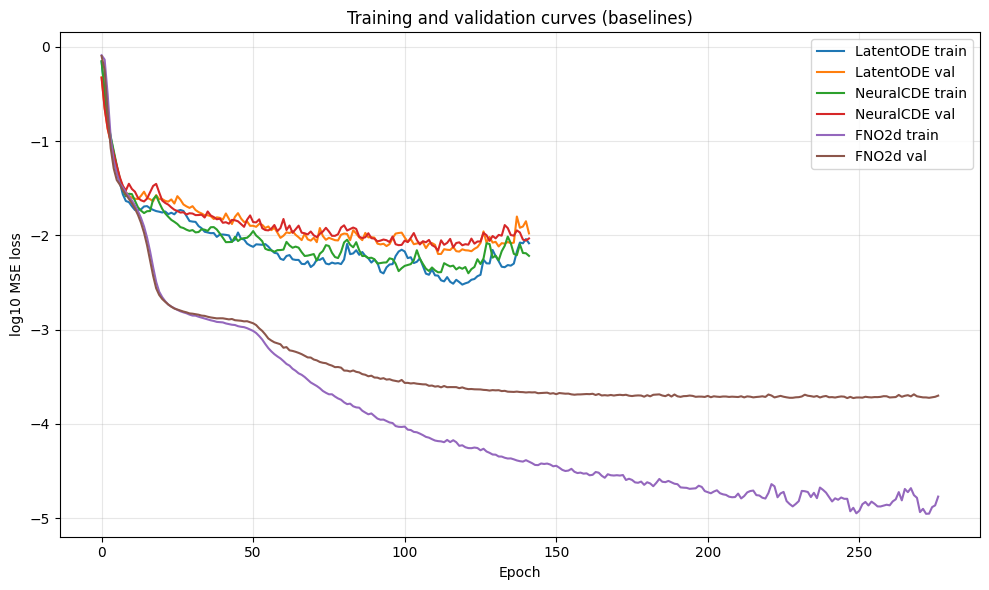

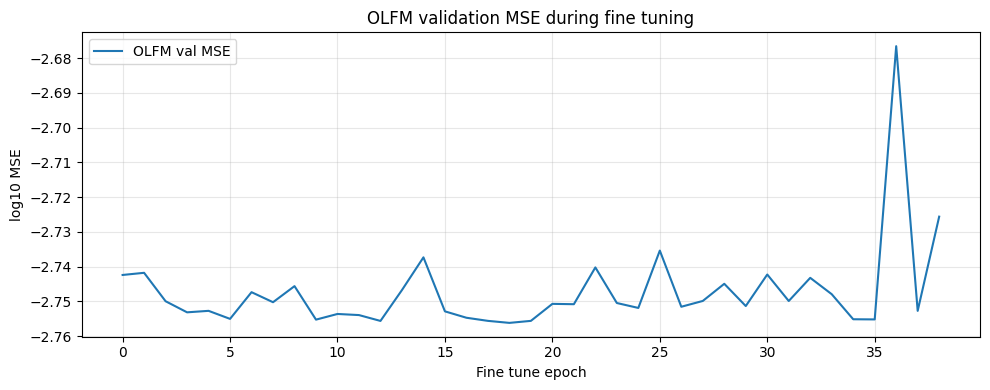

Plotting aggregated test MSE summary across models (linear scale)...


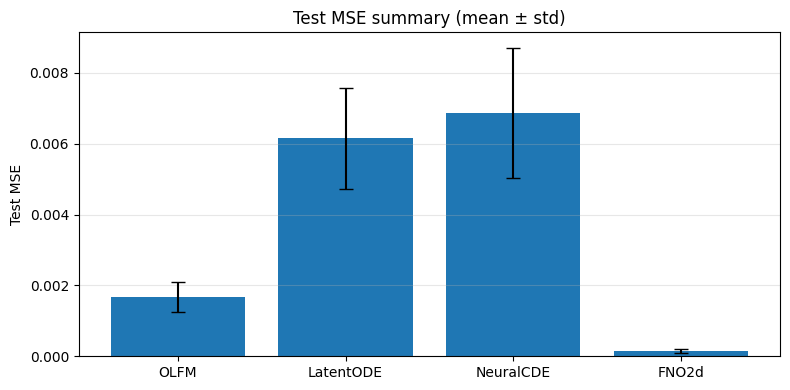

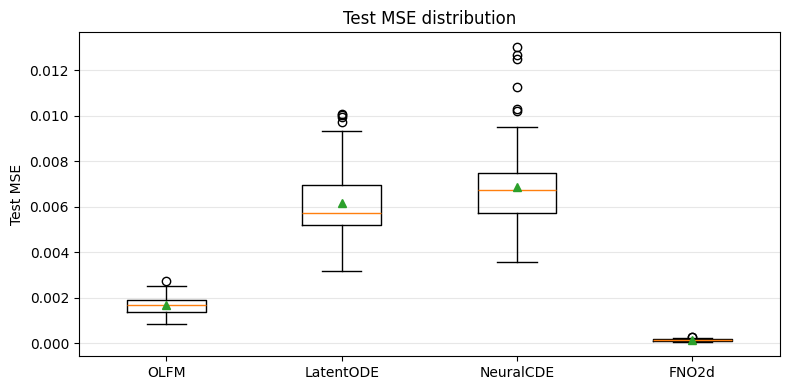

Plotting aggregated test MSE summary across models (log scale)...


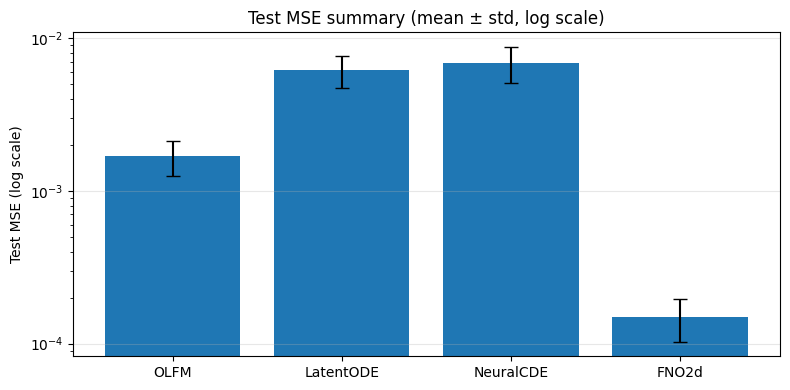

Plotting zoomed test MSE summary (excluding FNO2d)...


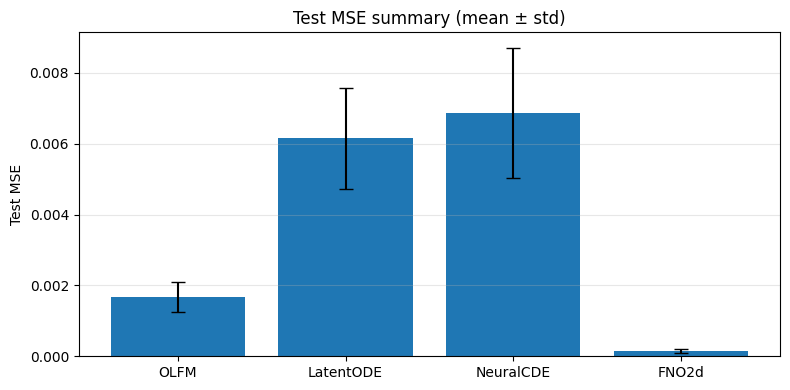

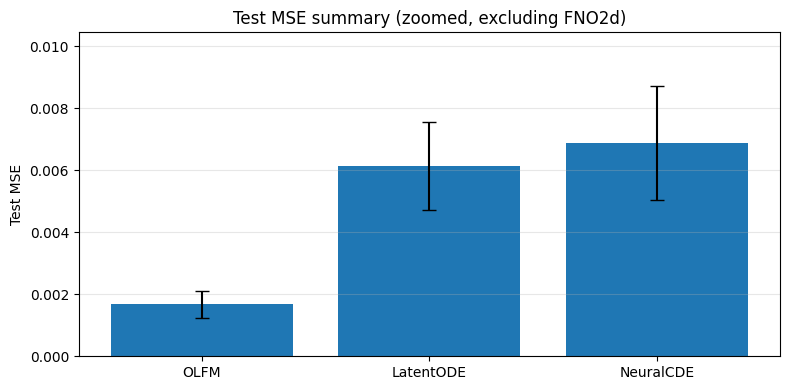

Plotting relative test MSE summary (normalised by OLFM)...


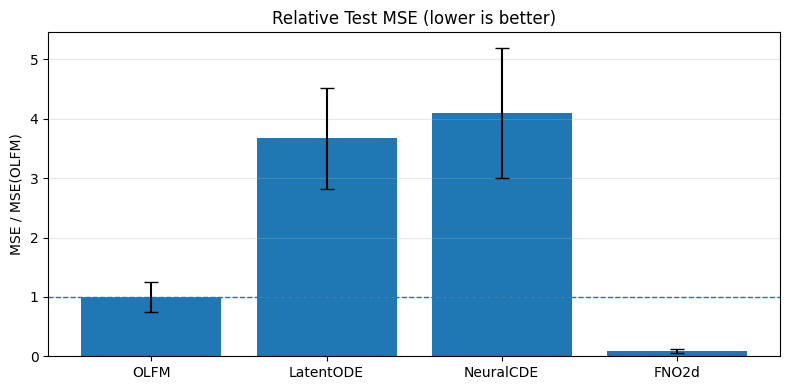

Plotting RMSE vs parameter count...


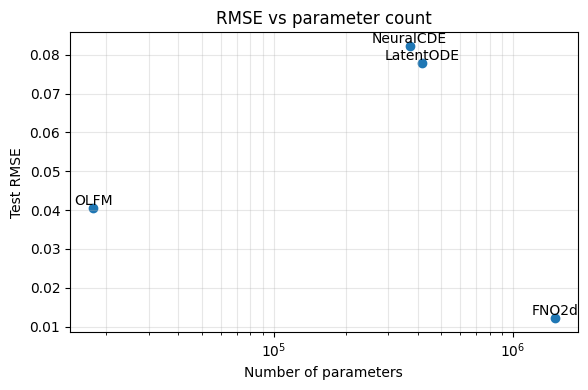

Plotting capacity adjusted error...


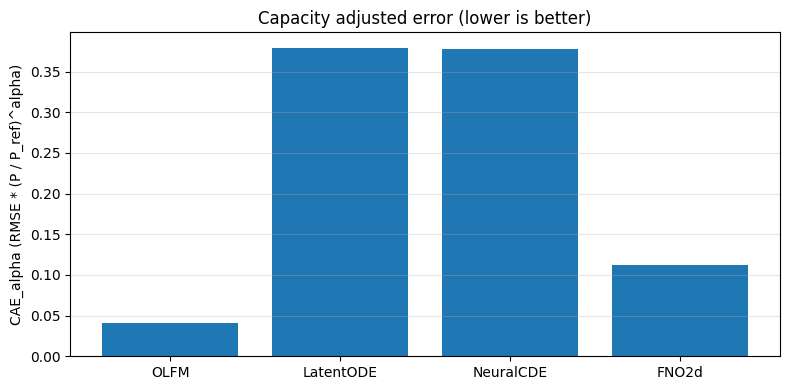

Plotting relative efficiency scores...


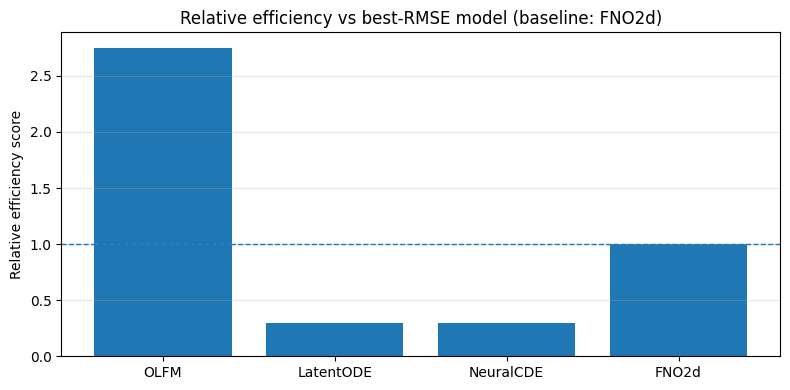

Plotting field comparisons for sample 0 (first seed)...


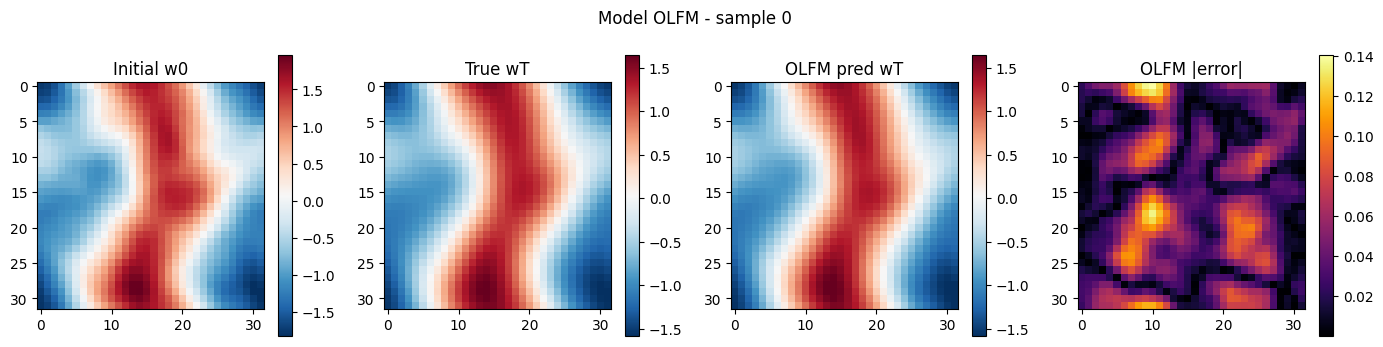

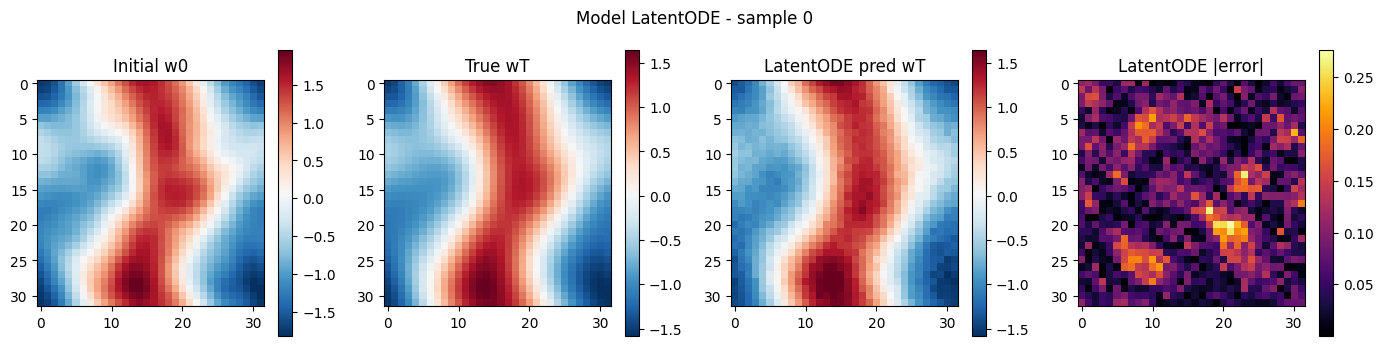

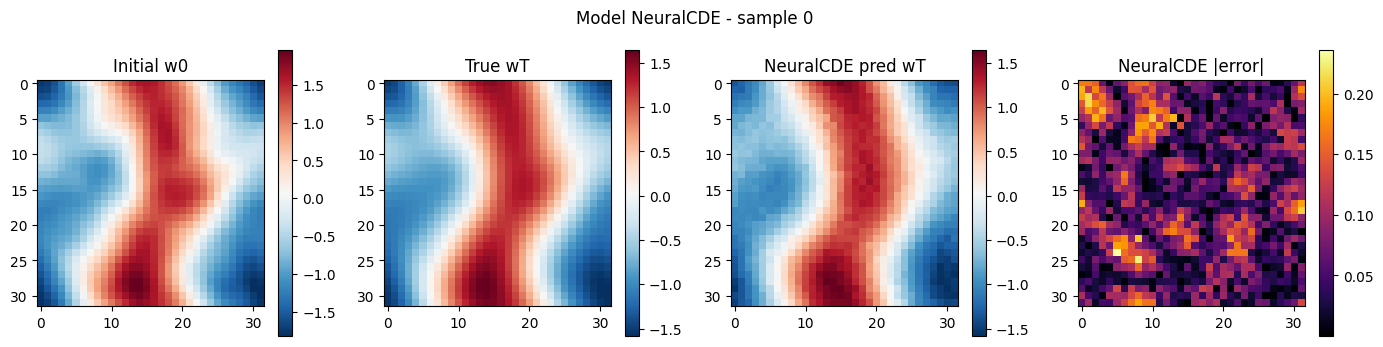

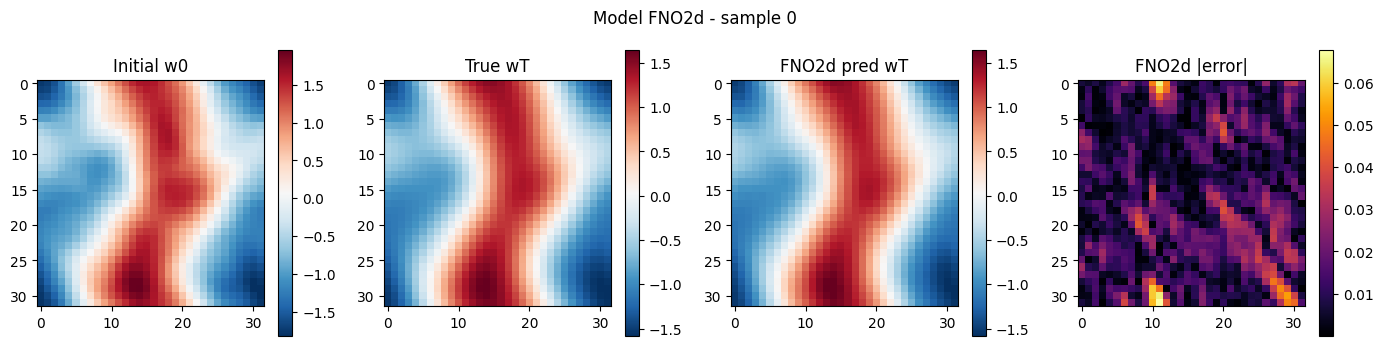

Plotting spectral comparison for sample 0 (first seed)...


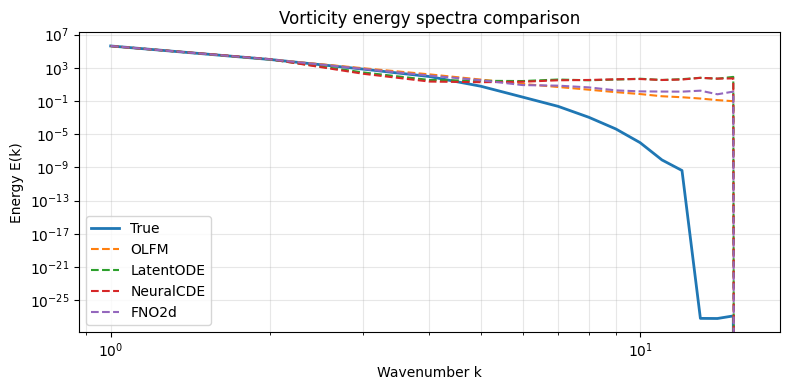

In [14]:
def main():
    cfg_base = NSConfig()
    print(f"Device: {DEVICE}")
    print(f"Grid size: {cfg_base.grid_size}x{cfg_base.grid_size}")

    model_names = ["OLFM", "LatentODE", "NeuralCDE", "FNO2d"]
    all_test_mses: Dict[str, List[np.ndarray]] = {name: [] for name in model_names}
    all_param_counts: Dict[str, List[int]] = {name: [] for name in model_names}
    param_counts: Dict[str, List[int]] = {name: [] for name in model_names}

    # Store histories and predictions from the first seed for plotting
    baseline_histories_first: Dict[str, Dict[str, List[float]]] | None = None
    olfm_hist_first: Dict[str, List[float]] | None = None
    preds_flat_first: Dict[str, np.ndarray] | None = None
    test_u0_first: np.ndarray | None = None
    test_uT_first: np.ndarray | None = None

    seed_values = list(range(cfg_base.num_seeds))

    for seed_idx, seed in enumerate(seed_values):
        print("\n" + "=" * 80)
        print(f"Outer seed {seed_idx + 1}/{len(seed_values)} (base seed {seed})")
        print("=" * 80)

        # Clone config and set seeds for this run
        cfg = copy.deepcopy(cfg_base)
        cfg.dataset_seed = seed
        cfg.split_seed = seed + 100
        cfg.model_seed = seed + 200

        set_seed(cfg.model_seed)

        print("Generating 2D Navier-Stokes dataset...")
        initials, finals = build_dataset(cfg)
        print("Data shape:", initials.shape)

        (
            train_u0,
            train_uT,
            val_u0,
            val_uT,
            test_u0,
            test_uT,
            train_loader,
            val_loader,
            test_loader,
        ) = make_splits(cfg, initials, finals)

        # Match training budget in number of gradient updates
        updates_per_epoch = len(train_loader)
        total_epochs = max(1, cfg.fair_total_updates // max(1, updates_per_epoch))
        cfg.baseline_epochs = total_epochs
        print(
            f"Using {total_epochs} epochs for all models "
            f"(~{total_epochs * updates_per_epoch} gradient updates)"
        )

        input_dim = cfg.grid_size * cfg.grid_size

        # ----------------------------- OLFM with search -------------------
        print("\nTraining OLFM (with hyperparameter search)...")
        olfm_model, olfm_hist, olfm_hps = train_olfm_with_search(
            cfg,
            train_u0,
            train_uT,
            val_u0,
            val_uT,
            total_epochs=total_epochs,
        )

        # --------------------------- Baselines with search ----------------
        print("\nTraining Latent ODE baseline (with hyperparameter search)...")
        latent_ode_model, hist_latent_ode, latent_hps = train_latent_ode_with_search(
            cfg,
            input_dim,
            train_loader,
            val_loader,
        )

        print("\nTraining Neural CDE baseline (with hyperparameter search)...")
        neural_cde_model, hist_neural_cde, cde_hps = train_neural_cde_with_search(
            cfg,
            input_dim,
            train_loader,
            val_loader,
        )

        print("\nTraining FNO baseline (with hyperparameter search)...")
        fno_regression_model, hist_fno, fno_hps = train_fno_with_search(
            cfg,
            cfg.grid_size,
            train_loader,
            val_loader,
        )

        # Record parameter counts for the final selected models on this seed
        params_olfm = count_parameters(olfm_model)
        params_latent = count_parameters(latent_ode_model)
        params_neuralcde = count_parameters(neural_cde_model)
        params_fno = count_parameters(fno_regression_model)

        param_counts["OLFM"].append(params_olfm)
        param_counts["LatentODE"].append(params_latent)
        param_counts["NeuralCDE"].append(params_neuralcde)
        param_counts["FNO2d"].append(params_fno)

        # Store parameter counts for this seed (after hyperparameter search)
        param_counts_seed = {
            "OLFM": count_parameters(olfm_model),
            "LatentODE": count_parameters(latent_ode_model),
            "NeuralCDE": count_parameters(neural_cde_model),
            "FNO2d": count_parameters(fno_regression_model),
        }
        for name in model_names:
            all_param_counts[name].append(param_counts_seed[name])

        # Collect histories for first seed for plotting
        if seed_idx == 0:
            baseline_histories_first = {
                "LatentODE": hist_latent_ode,
                "NeuralCDE": hist_neural_cde,
                "FNO2d": hist_fno,
            }
            baseline_histories_first["OLFM"] = olfm_hist
            olfm_hist_first = olfm_hist
            test_u0_first = test_u0
            test_uT_first = test_uT

        # --------------------------- Evaluation ---------------------------
        print("\nEvaluating all models on test set...")
        olfm_mse, olfm_pred_flat, _ = evaluate_olfm_model(
            olfm_model,
            test_u0,
            test_uT,
            steps=100,
        )
        latent_mse, latent_pred_flat, _ = evaluate_flat_model(
            latent_ode_model,
            test_loader,
        )
        cde_mse, cde_pred_flat, _ = evaluate_flat_model(
            neural_cde_model,
            test_loader,
        )
        fno_mse, fno_pred_flat, _ = evaluate_flat_model(
            fno_regression_model,
            test_loader,
        )

        test_mses_seed: Dict[str, np.ndarray] = {
            "OLFM": olfm_mse,
            "LatentODE": latent_mse,
            "NeuralCDE": cde_mse,
            "FNO2d": fno_mse,
        }

        for name in model_names:
            all_test_mses[name].append(test_mses_seed[name])

        if seed_idx == 0:
            preds_flat_first = {
                "OLFM": olfm_pred_flat,
                "LatentODE": latent_pred_flat,
                "NeuralCDE": cde_pred_flat,
                "FNO2d": fno_pred_flat,
            }

        print("\nTest MSE for this seed (mean over test set):")
        for name, mse_vals in test_mses_seed.items():
            print(f" {name:10s}: {mse_vals.mean():.4e} ± {mse_vals.std():.4e}")

    # Aggregate over seeds
    aggregated_test_mses: Dict[str, np.ndarray] = {
        name: np.concatenate(all_test_mses[name], axis=0) for name in model_names
    }

    print("\n" + "=" * 80)
    print("Aggregated test MSE over all seeds (per sample, concatenated):")
    print("=" * 80)
    for name, mse_vals in aggregated_test_mses.items():
        print(f" {name:10s}: {mse_vals.mean():.4e} ± {mse_vals.std():.4e}")

    # ---------------------- Parameter efficiency metrics ----------------------
    print("\n" + "=" * 80)
    print("Parameter efficiency metrics (aggregated over seeds):")
    print("=" * 80)
    metrics = compute_param_efficiency_metrics(
        aggregated_test_mses,
        all_param_counts,
        alpha=cfg_base.param_eff_alpha,
        p_ref=None,
    )
    print_param_efficiency_table(metrics)

    # ------------------------ Parameter count summary -------------------
    print("\n" + "=" * 80)
    print("Parameter counts (per seed and mean):")
    print("=" * 80)
    mean_params: Dict[str, float] = {}
    for name in model_names:
        vals = np.array(param_counts[name], dtype=float)
        mean_params[name] = vals.mean()
        unique_vals = sorted(set(param_counts[name]))
        if len(unique_vals) == 1:
            print(f" {name:10s}: {unique_vals[0]:d}")
        else:
            print(f" {name:10s}: {param_counts[name]} (mean {vals.mean():.1f})")

    base_params = mean_params["OLFM"]
    print("\nParameter ratios relative to OLFM:")
    for name in model_names:
        ratio = mean_params[name] / base_params
        print(f" {name:10s}: {ratio:8.2f} x OLFM")

    # ----------------------------- Plots --------------------------------
    if baseline_histories_first is not None and olfm_hist_first is not None:
        print("\nPlotting training and validation curves for first seed...")
        plot_training_curves(baseline_histories_first, y_transform="log")

    # Aggregate MSE plots
    print("Plotting aggregated test MSE summary across models (linear scale)...")
    plot_mse_summary(aggregated_test_mses)

    print("Plotting aggregated test MSE summary across models (log scale)...")
    plot_mse_summary_log(aggregated_test_mses)

    print("Plotting zoomed test MSE summary (excluding FNO2d)...")
    plot_mse_summary_zoomed(aggregated_test_mses)

    print("Plotting relative test MSE summary (normalised by OLFM)...")
    plot_mse_summary_relative(aggregated_test_mses)

    # Parameter-aware plots
    print("Plotting RMSE vs parameter count...")
    plot_error_vs_params(metrics)

    print("Plotting capacity adjusted error...")
    plot_capacity_adjusted_error(metrics)

    print("Plotting relative efficiency scores...")
    plot_relative_efficiency(metrics)

    # Field and spectrum plots from first seed
    if (
        preds_flat_first is not None
        and test_u0_first is not None
        and test_uT_first is not None
    ):
        sample_idx = 0
        print(f"Plotting field comparisons for sample {sample_idx} (first seed)...")
        plot_field_comparisons(
            NSConfig(grid_size=test_u0_first.shape[-1]),
            test_u0_first,
            test_uT_first,
            preds_flat_first,
            sample_idx=sample_idx,
        )

        print(f"Plotting spectral comparison for sample {sample_idx} (first seed)...")
        plot_spectrum_comparison(
            NSConfig(grid_size=test_uT_first.shape[-1]),
            test_uT_first,
            preds_flat_first,
            sample_idx=sample_idx,
        )

if __name__ == "__main__":
    main()